# Imports

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import PIL

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_location = '/home/marcin/Datasets/camvid/'

# CamVid Dataset

In [4]:
def download(url, dest, md5sum):
    import os
    import urllib
    import hashlib

    folder, file = os.path.split(dest)
    if folder != '':
        os.makedirs(folder, exist_ok=True)
    if not os.path.isfile(dest):
        print('Downloading', file, '...')
        urllib.request.urlretrieve(url, dest)
    else:
        print('Already Exists:', file)
    assert hashlib.md5(open(dest, 'rb').read()).hexdigest() == md5sum

In [5]:
download(url='https://github.com/alexgkendall/SegNet-Tutorial/archive/master.zip',
         dest=os.path.join(dataset_location, 'master.zip'),
         md5sum='9a61b9d172b649f6e5da7e8ebf75338f')

Already Exists: master.zip


In [6]:
def extract(src, dest):
    import os
    import zipfile
    
    path, file = os.path.split(src)
    extract_path, _ = os.path.splitext(src)
    already_extracted = os.path.isdir(dest)
    if not already_extracted:
        with zipfile.ZipFile(src, 'r') as zf:
            print('Extracting', file, '...')
            zf.extractall(dest)
    else:
        print('Already Extracted:', file)       
    assert os.path.isdir(extract_path)

In [7]:
extract(src=os.path.join(dataset_location, 'master.zip'),
        dest=os.path.join(dataset_location, 'master'))

Already Extracted: master.zip


In [10]:
   
    
class camvidLoader(torch.utils.data.Dataset):
    def __init__(
        self,
        root,
        split="train",
        is_transform=False,
        img_size=None,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.split = split
        self.img_size = [360, 480]
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.n_classes = 12
        self.files = collections.defaultdict(list)

        if not self.test_mode:
            for split in ["train", "test", "val"]:
                file_list = os.listdir(root + "/" + split)
                self.files[split] = file_list

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_name = self.files[self.split][index]
        img_path = self.root + "/" + self.split + "/" + img_name
        lbl_path = self.root + "/" + self.split + "annot/" + img_name

        img = m.imread(img_path)
        img = np.array(img, dtype=np.uint8)

        lbl = m.imread(lbl_path)
        lbl = np.array(lbl, dtype=np.uint8)

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        return img, lbl

    def transform(self, img, lbl):
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

    def decode_segmap(self, temp, plot=False):
        Sky = [128, 128, 128]
        Building = [128, 0, 0]
        Pole = [192, 192, 128]
        Road = [128, 64, 128]
        Pavement = [60, 40, 222]
        Tree = [128, 128, 0]
        SignSymbol = [192, 128, 128]
        Fence = [64, 64, 128]
        Car = [64, 0, 128]
        Pedestrian = [64, 64, 0]
        Bicyclist = [0, 128, 192]
        Unlabelled = [0, 0, 0]

        label_colours = np.array(
            [
                Sky,
                Building,
                Pole,
                Road,
                Pavement,
                Tree,
                SignSymbol,
                Fence,
                Car,
                Pedestrian,
                Bicyclist,
                Unlabelled,
            ]
        )
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

In [11]:
import scipy.misc as m
import collections

In [13]:
t_loader = camvidLoader(
    root=os.path.join(dataset_location, 'master/SegNet-Tutorial-master/CamVid'),
    split='train', is_transform=True, img_size=(360, 480))

In [14]:
img, lbl = t_loader[0]

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [15]:
lbl.max()

tensor(11)

In [17]:
t_loader.files['train'][0]

'0001TP_008460.png'

In [18]:
import functools

class fcn32s(nn.Module):
    def __init__(self, n_classes=21, learned_billinear=False):
        super(fcn32s, self).__init__()
        self.learned_billinear = learned_billinear
        self.n_classes = n_classes
        self.loss = functools.partial(cross_entropy2d, size_average=False)

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=100),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, self.n_classes, 1),
        )

        if self.learned_billinear:
            raise NotImplementedError

    def forward(self, x):
        conv1 = self.conv_block1(x)
        conv2 = self.conv_block2(conv1)
        conv3 = self.conv_block3(conv2)
        conv4 = self.conv_block4(conv3)
        conv5 = self.conv_block5(conv4)

        score = self.classifier(conv5)

        out = F.upsample(score, x.size()[2:])

        return out

    def init_vgg16_params(self, vgg16, copy_fc8=True):
        blocks = [
            self.conv_block1,
            self.conv_block2,
            self.conv_block3,
            self.conv_block4,
            self.conv_block5,
        ]

        ranges = [[0, 4], [5, 9], [10, 16], [17, 23], [24, 29]]
        features = list(vgg16.features.children())

        for idx, conv_block in enumerate(blocks):
            for l1, l2 in zip(features[ranges[idx][0] : ranges[idx][1]], conv_block):
                if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                    assert l1.weight.size() == l2.weight.size()
                    assert l1.bias.size() == l2.bias.size()
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data
        for i1, i2 in zip([0, 3], [0, 3]):
            l1 = vgg16.classifier[i1]
            l2 = self.classifier[i2]
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())
        n_class = self.classifier[6].weight.size()[0]
        if copy_fc8:
            l1 = vgg16.classifier[6]
            l2 = self.classifier[6]
            l2.weight.data = l1.weight.data[:n_class, :].view(l2.weight.size())
            l2.bias.data = l1.bias.data[:n_class]


In [19]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss

In [20]:
model = fcn32s(n_classes=12)
vgg16 = models.vgg16(pretrained=True)
model.init_vgg16_params(vgg16)

In [ ]:
res = model(img.expand(1, -1, -1, -1))

In [36]:
def plot_all(img, res, lbl):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=[16,9])
    
    kkk = np.array(img.numpy().transpose(1, 2, 0)*255 + t_loader.mean, dtype=int)
    kkk = kkk[:,:,::-1]
    ax1.imshow(kkk)
    
    arr = np.argmax( res.detach()[0].numpy(), axis=0)    # res to numpy
    ax2.imshow(t_loader.decode_segmap(arr))
    
    ax3.imshow(t_loader.decode_segmap(lbl.numpy()))

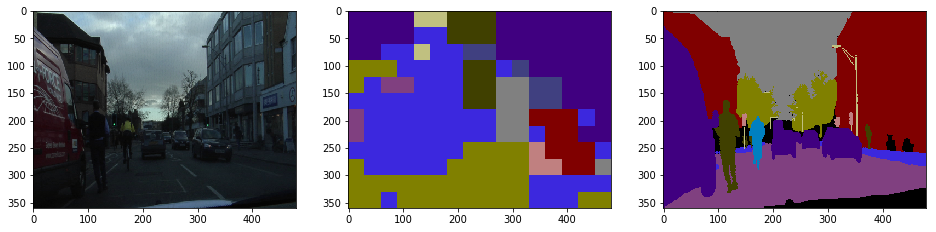

In [37]:
plot_all(img, res, lbl)

In [ ]:
for e in range(300000)